In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols, glm
import statsmodels.api as sm
import re

In [63]:
data = pd.read_csv("../data/curated/listings_with_distances.csv")
school = pd.read_csv("../data/curated/Closest_and_average_dist_school.csv")
neighbour = pd.read_csv("../data/curated/neigh_stat.csv")

In [31]:
data = pd.merge(data, school, left_on='id', right_on='listing_id')
data[["id", "Suburb", "price", "beds", "baths", "parking", "title", "address", "propertyType", "status", "bond", "Coordinates", "Latitude", "Longitude", "ClosestDstToShoppingCentre", "DstToCBD", "ClosestShop", "ClosestDstToStation", "ClosestStation", "ClosestDstToUni", "ClosestUni", "closest_school", "dist_closest_school", "ave_dist_3_schools"]]\
.to_csv("../data/curated/listings_with_distances.csv", index = False)

In [64]:
data = pd.merge(data, neighbour, left_on='id', right_on='id')

In [5]:
def get_Suburb(x:str):
    try:
        suburb = re.findall(", [A-Za-z ]+ VIC", x)[0]
        suburb = re.sub(", || VIC", "", suburb)
    except IndexError:
        suburb = None
    return suburb
data["Suburb"] = data["address"].apply(lambda x: get_Suburb(x))
#get_Suburb("level1, 208/16 Anderson Street, West Melbourne VIC")

In [50]:
data.to_csv("../data/curated/listings_with_distances.csv", index = False)

In [65]:
COLS = ["price", "Suburb", "beds","propertyType", "closest_school", "dist_closest_school","ave_dist_3_schools", "ClosestDstToShoppingCentre", "DstToCBD", "ClosestShop", "ClosestDstToStation", "ClosestStation", "ClosestDstToUni", "ClosestUni", "age0To19", "age20To39", "age40To59","age60Plus","longTermResident","owner","renter","family","single"]
CORR_COLS = ["price", "ClosestDstToShoppingCentre", "DstToCBD", "ClosestDstToStation", "ClosestDstToUni", "dist_closest_school","ave_dist_3_schools", "age0To19", "age20To39", "age40To59","age60Plus","longTermResident","owner","renter","family","single"]
DISCRETE_COLS = ["Suburb", "closest_school", "ClosestShop", "ClosestStation", "ClosestUni"]
data = data[COLS]

In [66]:
data = data[data['ClosestDstToShoppingCentre'] < 100000]
data = data[data['ClosestDstToStation'] < 100000]
data = data[data['DstToCBD'] < 100000] 
data = data[data['ClosestDstToUni'] < 100000]


In [67]:
bed_4_house = data[(data["beds"] == 4) & (data["propertyType"] == "House")]
bed_3_house = data[(data["beds"] == 3) & (data["propertyType"] == "House")]
bed_2_house = data[(data["beds"] == 2) & (data["propertyType"] == "House")]
bed_3_flat = data[(data["beds"] == 3) & (data["propertyType"] == "Apartment / Unit / Flat")]
bed_2_flat = data[(data["beds"] == 2) & (data["propertyType"] == "Apartment / Unit / Flat")]
bed_1_flat = data[(data["beds"] == 1) & (data["propertyType"] == "Apartment / Unit / Flat")]

In [19]:
bed_3_house[bed_3_house["Suburb"] == "Ringwood"]

,price,Suburb,beds,propertyType,closest_school,dist_closest_school,ave_dist_3_schools,ClosestDstToShoppingCentre,DstToCBD,ClosestShop,...,ClosestUni,age0To19,age20To39,age40To59,age60Plus,longTermResident,owner,renter,family,single
820,520.0,Ringwood,3,House,Our Lady of Perpetual Help School,607.204014,645.612680,1354.8,28064.1,EASTLAND SHOPPING CENTRE Victoria,...,Swinburne University of Technology,0.205128,0.263736,0.300366,0.230769,0.644898,0.687500,0.312500,0.554502,0.445498
3145,480.0,Ringwood,3,House,Indie School Wodonga - Indie School Ringwood C...,796.400844,923.065858,850.0,27685.8,RINGWOOD SQUARE SHOPPING CENTRE Victoria,...,Swinburne University of Technology,0.204738,0.385787,0.285956,0.123519,0.330986,0.305970,0.694030,0.502193,0.497807
3663,520.0,Ringwood,3,House,Marlborough Primary School,912.457625,1059.131601,2550.1,29282.9,EASTLAND SHOPPING CENTRE Victoria,...,Swinburne University of Technology,0.245333,0.285333,0.293333,0.176000,0.669291,0.750000,0.250000,0.535714,0.464286
4161,350.0,Ringwood,3,House,Our Lady of Perpetual Help School,1001.334749,1067.718160,516.0,28028.5,RINGWOOD SQUARE SHOPPING CENTRE Victoria,...,Swinburne University of Technology,0.204738,0.385787,0.285956,0.123519,0.330986,0.305970,0.694030,0.502193,0.497807
4367,450.0,Ringwood,3,House,Mullum Primary School,647.294593,806.021922,1326.5,28518.6,EASTLAND SHOPPING CENTRE Victoria,...,Swinburne University of Technology,0.279778,0.216066,0.274238,0.229917,0.711538,0.818182,0.181818,0.632184,0.367816
5613,450.0,Ringwood,3,House,Indie School Wodonga - Indie School Ringwood C...,119.007998,456.266459,844.5,28389.8,EASTLAND SHOPPING CENTRE Victoria,...,Swinburne University of Technology,0.248963,0.278008,0.269710,0.203319,0.307692,0.266667,0.733333,0.402516,0.597484
5943,440.0,Ringwood,3,House,Mullum Primary School,625.512840,792.541177,2629.6,29821.7,EASTLAND SHOPPING CENTRE Victoria,...,Swinburne University of Technology,0.279778,0.216066,0.274238,0.229917,0.711538,0.818182,0.181818,0.632184,0.367816
6122,470.0,Ringwood,3,House,Mullum Primary School,1006.572536,1165.705096,667.0,27425.4,RINGWOOD SQUARE SHOPPING CENTRE Victoria,...,Swinburne University of Technology,0.222449,0.273469,0.234694,0.269388,0.550000,0.643750,0.356250,0.561562,0.438438
6844,470.0,Ringwood,3,House,Antonio Park Primary School,771.701853,1361.743693,974.6,26782.6,RINGWOOD SQUARE SHOPPING CENTRE Victoria,...,Swinburne University of Technology,0.225225,0.342342,0.279279,0.153153,0.447619,0.775510,0.224490,0.484536,0.515464
8886,370.0,Ringwood,3,House,Antonio Park Primary School,783.115200,1382.505984,1332.4,27140.5,RINGWOOD SQUARE SHOPPING CENTRE Victoria,...,Swinburne University of Technology,0.225225,0.342342,0.279279,0.153153,0.447619,0.775510,0.224490,0.484536,0.515464


In [43]:
len(bed_2_flat[bed_2_flat["Suburb"] == "Toorak"])

18

In [42]:
bed_2_flat[bed_2_flat["Suburb"] == "Toorak"][CORR_COLS].corr()
#sns.heatmap(bed_2_house[CORR_COLS].corr())

,price,ClosestDstToShoppingCentre,DstToCBD,ClosestDstToStation,ClosestDstToUni,dist_closest_school,ave_dist_3_schools,age0To19,age20To39,age40To59,age60Plus,longTermResident,owner,renter,family,single
price,1.000000,0.168688,0.362495,0.418602,0.348704,-0.091798,-0.170252,-0.094078,0.165178,0.349967,-0.181586,0.220484,-0.053901,0.053901,0.053443,-0.053443
ClosestDstToShoppingCentre,0.168688,1.000000,0.684380,0.007485,0.341808,0.045835,-0.232526,0.199714,0.407529,-0.178768,-0.442647,0.184228,-0.034778,0.034778,-0.037422,0.037422
DstToCBD,0.362495,0.684380,1.000000,0.097206,0.856165,-0.342129,-0.740905,-0.157141,0.712461,0.041677,-0.590109,-0.001239,-0.254974,0.254974,-0.402412,0.402411
ClosestDstToStation,0.418602,0.007485,0.097206,1.000000,-0.115819,-0.068474,0.206558,0.461094,-0.128326,0.236741,-0.170584,-0.034567,0.034233,-0.034233,0.438270,-0.438270
ClosestDstToUni,0.348704,0.341808,0.856165,-0.115819,1.000000,-0.358947,-0.826566,-0.498617,0.837697,0.170072,-0.558359,-0.197758,-0.510686,0.510686,-0.700206,0.700206
dist_closest_school,-0.091798,0.045835,-0.342129,-0.068474,-0.358947,1.000000,0.671671,-0.266289,-0.297444,-0.256831,0.470104,0.380274,0.251770,-0.251770,0.089975,-0.089975
ave_dist_3_schools,-0.170252,-0.232526,-0.740905,0.206558,-0.826566,0.671671,1.000000,0.339536,-0.576284,-0.174730,0.398558,0.255034,0.398043,-0.398043,0.580721,-0.580720
age0To19,-0.094078,0.199714,-0.157141,0.461094,-0.498617,-0.266289,0.339536,1.000000,-0.196974,-0.137956,-0.302883,-0.150845,0.125826,-0.125826,0.624540,-0.624540
age20To39,0.165178,0.407529,0.712461,-0.128326,0.837697,-0.297444,-0.576284,-0.196974,1.000000,0.103636,-0.850329,-0.486246,-0.720777,0.720777,-0.683782,0.683782
age40To59,0.349967,-0.178768,0.041677,0.236741,0.170072,-0.256831,-0.174730,-0.137956,0.103636,1.000000,-0.244105,-0.178151,-0.165596,0.165596,0.007315,-0.007315


In [292]:
MOST_CORR = ["price", "DstToCBD", "age0To19", "age20To39", "ClosestDstToUni", "longTermResident", "owner"]

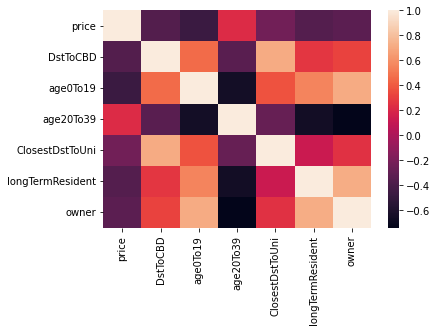

In [294]:
bed_2_flat[MOST_CORR].corr()
sns.heatmap(bed_3_flat[MOST_CORR].corr())

In [55]:
bed_2_house.loc[:, "total"] = bed_2_house["ClosestDstToShoppingCentre"]+ bed_2_house["DstToCBD"]+bed_2_house["ClosestDstToStation"]+bed_2_house["dist_closest_school"]
bed_2_flat.loc[:, "total"] = bed_2_flat["ClosestDstToShoppingCentre"]+ bed_2_flat["DstToCBD"]+bed_2_flat["ClosestDstToStation"]+bed_2_flat["dist_closest_school"]
bed_1_flat.loc[:, "total"] = bed_1_flat["ClosestDstToShoppingCentre"]+ bed_1_flat["DstToCBD"]+bed_1_flat["ClosestDstToStation"]+bed_1_flat["dist_closest_school"]

/tmp/ipykernel_1033/4230284574.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bed_2_house.loc[:, "total"] = bed_2_house["ClosestDstToShoppingCentre"]+ bed_2_house["DstToCBD"]+bed_2_house["ClosestDstToStation"]+bed_2_house["dist_closest_school"]
/tmp/ipykernel_1033/4230284574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bed_2_flat.loc[:, "total"] = bed_2_flat["ClosestDstToShoppingCentre"]+ bed_2_flat["DstToCBD"]+bed_2_flat["ClosestDstToStation"]+bed_2_flat["dist_closest_school"]
/tmp/ipykernel_10

In [51]:
bed_2_house

,price,Suburb,beds,propertyType,closest_school,dist_closest_school,ave_dist_3_schools,ClosestDstToShoppingCentre,DstToCBD,ClosestShop,...,age0To19,age20To39,age40To59,age60Plus,longTermResident,owner,renter,family,single,total
7,460.0,Lyndhurst,2,House,Lyndhurst Primary School,343.406326,900.448873,2818.6,46587.7,CRANBOURNE HOMEMAKER CENTRE Victoria,...,0.411687,0.272244,0.289509,0.026560,0.000000,0.834197,0.165803,0.796909,0.203091,51853.906326
10,700.0,Clifton Hill,2,House,Spensley Street Primary School,739.444538,941.729729,3442.0,5306.7,NORTHCOTE SHOPPING PLAZA Victoria,...,0.304348,0.249527,0.317580,0.128544,0.479358,0.636364,0.363636,0.592493,0.407507,10304.044538
22,550.0,Sandringham,2,House,St Agnes' School,779.808201,938.226410,3147.4,20777.8,HIGHETT SHOPPING CENTRE Victoria,...,0.330017,0.162521,0.247098,0.260365,0.549894,0.855491,0.144509,0.623269,0.376731,26813.908201
28,525.0,Southbank,2,House,Hester Hornbrook Academy,488.686119,558.380379,1371.7,2086.3,SPENCER STREET FASHION STATION Victoria,...,0.077634,0.652495,0.238447,0.031423,0.589286,0.188889,0.811111,0.325843,0.674157,5329.186119
41,450.0,Surrey Hills,2,House,Our Lady of Perpetual Succour School,68.658674,611.344221,2715.0,14653.5,BOX HILL CENTRAL Victoria,...,0.326496,0.196581,0.283761,0.193162,0.690763,0.882682,0.117318,0.642157,0.357843,19157.158674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11907,385.0,Chadstone,2,House,Berengarra School - Café Education,204.205707,396.206918,838.0,17688.7,HOMEPLUS HOMEMAKER CENTRE Victoria,...,0.173152,0.482490,0.219844,0.124514,0.450226,0.419753,0.580247,0.362944,0.637056,19525.605707
11918,340.0,Altona Meadows,2,House,Seabrook Primary School,1253.912758,1750.338214,963.5,23981.2,CENTRAL SQUARE SHOPPING CENTRE Victoria,...,0.274766,0.246729,0.300935,0.177570,0.687646,0.651282,0.348718,0.624685,0.375315,28945.712758
11967,340.0,Braybrook,2,House,Rosamond Special School,394.014243,606.879945,788.9,11415.0,CENTRAL WEST SHOPPING CENTRE Victoria,...,0.255639,0.387218,0.218045,0.139098,0.629213,0.372781,0.627219,0.432361,0.567639,14224.914243
11972,400.0,Ivanhoe,2,House,St Bernadette's School,616.481723,719.494550,739.8,10674.2,IVANHOE PLAZA Victoria,...,0.278539,0.189498,0.315068,0.216895,0.730994,0.866667,0.133333,0.629630,0.370370,13627.981723


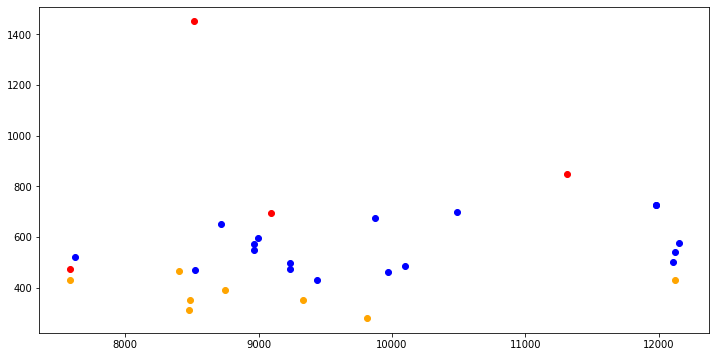

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter("total", "price", color="blue", data=bed_2_flat[bed_2_flat["Suburb"] == "Toorak"])
ax.scatter("total", "price", color="red", data=bed_2_house[bed_2_house["Suburb"] == "Toorak"])
ax.scatter("total", "price", color="orange", data=bed_1_flat[bed_1_flat["Suburb"] == "Toorak"])


(0.0, 2000.0)

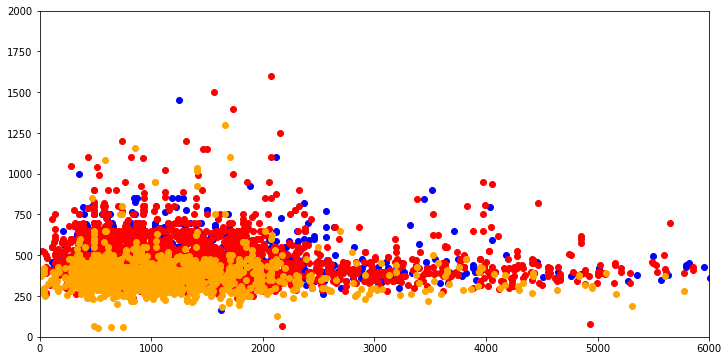

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter("ClosestDstToStation", "price", color="blue", data=bed_2_house)
ax.scatter("ClosestDstToStation", "price", color="red", data=bed_2_flat)
ax.scatter("ClosestDstToStation", "price", color="orange", data=bed_1_flat)
plt.xlim(0, 6000)
plt.ylim(0, 2000)

## ANOVAS

Removing outliers for each suburb

In [71]:
def remove_outlier(dataframe):
    df = pd.DataFrame()
    for suburb in dataframe["Suburb"].unique():
        prices = dataframe[dataframe["Suburb"] == suburb]["price"]
        if len(prices) > 0:
            mean = prices.sum()/len(prices)
            sd = ((prices-mean)*(prices-mean)).sum()/(len(prices))
            df = pd.concat([df, dataframe[(dataframe.Suburb == suburb) & (dataframe.price < mean + 1.5*sd) & (dataframe.price > mean - 1.5*sd)]])
    return df


In [72]:
bed_1_flat_clean = remove_outlier(bed_1_flat)
bed_2_flat_clean = remove_outlier(bed_2_flat)
bed_2_house_clean = remove_outlier(bed_2_house)

### Back ward elimination

In [95]:
query = "price~ave_dist_3_schools+ClosestShop+ClosestStation+closest_school+ClosestDstToShoppingCentre+DstToCBD+ClosestDstToStation+Suburb+ClosestDstToUni+age0To19+age20To39+age40To59+age60Plus+longTermResident+owner+renter+family+single"

In [96]:
def back_ward_elim(dataframe):
    P_VALUE = 0.05
    stats_query =  query
    model = ols(stats_query, data = dataframe).fit()
    anova = sm.stats.anova_lm(model,typ=2)
    while len(anova[anova["PR(>F)"] >= P_VALUE]) > 0:
        max_p = max(anova["PR(>F)"])
        eliminated_param = anova[anova["PR(>F)"] == max_p].index[0]
        stats_query = re.sub(eliminated_param, "", stats_query)
        stats_query = re.sub("\+\+", "+", stats_query)
        stats_query = re.sub("\+$", "", stats_query)
        model = ols(stats_query, data = dataframe).fit()
        anova = sm.stats.anova_lm(model,typ=2)
    return anova, model

    

In [97]:
bed_1_flat_anova, bed_1_flat_model = back_ward_elim(bed_1_flat_clean)
bed_2_flat_anova, bed_2_flat_model = back_ward_elim(bed_2_flat_clean)
bed_2_house_anova, bed_2_house_model = back_ward_elim(bed_2_house_clean)

/home/ohanr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 196, but rank is 164
  warnings.warn('covariance of constraints does not have full '
/home/ohanr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 562, but rank is 536
  warnings.warn('covariance of constraints does not have full '
/home/ohanr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 189, but rank is 188
  warnings.warn('covariance of constraints does not have full '
/home/ohanr/.local/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 196, but rank is 164
  warnings.warn('covariance 

In [98]:
bed_1_flat_anova

,sum_sq,df,F,PR(>F)
ClosestShop,3.617060e+06,73.0,3.783044,2.881609e-21
ClosestStation,3.762454e+06,121.0,2.374075,7.973040e-13
ClosestDstToUni,5.965515e+04,1.0,4.554666,3.309621e-02
age0To19,2.308598e+05,1.0,17.626126,2.953015e-05
age20To39,2.088835e+05,1.0,15.948234,7.035552e-05
family,6.481137e+04,1.0,4.948343,2.636058e-02
Residual,1.190571e+07,909.0,NaN,NaN


In [99]:
bed_1_flat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     3.898
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           5.40e-41
Time:                        23:18:41   Log-Likelihood:                -6586.5
No. Observations:                1085   AIC:                         1.353e+04
Df Residuals:                     909   BIC:                         1.440e+04
Df Model:                         175                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               523.9070     84.425      6.206      0.000     358.217     689.597
ClosestShop[T.ALTONA GATE SHOPPING CENTRE Victoria]                     -71.5615    176.595     -0.405      0.685    -418.144     275.021
ClosestShop[T.BARKLY SQUARE Victoria]                                    21.1703    121.934      0.174      0.862    -218.135     260.475
ClosestShop[T.BARRABOOL HILLS PLAZA Victoria]                           -12.7366     65.286     -0.195      0.845    -140.866     115.392
ClosestShop[T.BAYSIDE SHOPPING CENTRE Victoria]                         278.6357    127.697      2.182      0.029      28.020     529.251
ClosestShop[T.BELLPOST SHOPPING CENTRE Victoria]                        -66.6638    131.550     -0.507      0.612    -324.841     191.513
ClosestShop[T.BELMONT VILLAGE Victoria]                                  70.5230    150.893      0.467      0.640    -225.616     366.662
ClosestShop[T.BOX HILL CENTRAL Victoria]                                -45.4101     45.733     -0.993      0.321    -135.165      44.345
ClosestShop[T.BRIMBANK CENTRAL SHOPPING CENTRE Victoria]                -56.0654     50.444     -1.111      0.267    -155.066      42.935
ClosestShop[T.BROADMEADOWS SHOPPING CENTRE Victoria]                    -11.6692    121.322     -0.096      0.923    -249.774     226.435
ClosestShop[T.CAMBERWELL SUNDAY MARKET Victoria]                        -36.6489    113.256     -0.324      0.746    -258.922     185.624
ClosestShop[T.CAMPBELLFIELD PLAZA Victoria]                              33.8777     83.072      0.408      0.684    -129.157     196.913
ClosestShop[T.CARNEGIE CENTRAL Victoria]                                -83.9054     72.011     -1.165      0.244    -225.233      57.423
ClosestShop[T.CAULFIELD PLAZA SHOPPING CENTRE Victoria]                  78.6286    129.112      0.609      0.543    -174.763     332.020
ClosestShop[T.CENTRO SUNSHINE MARKETPLACE Victoria]                    -141.6627    128.380     -1.103      0.270    -393.617     110.292
ClosestShop[T.CHADSTONE THE FASHION CAPITAL Victoria]                  1294.4737    142.407      9.090      0.000    1014.989    1573.959
ClosestShop[T.COBURG HILL SHOPPING CENTRE Victoria]                      37.1272    144.847      0.256      0.798    -247.147     321.401
ClosestShop[T.COLLINS PLACE Victoria]                                    60.3909     92.633      0.652      0.515    -121.409     242.191
ClosestShop[T.COLLINS234 BOUTIQUE PLACE Victoria]                        98.7125    100.247      0.985      0.325     -98.030     295.455
ClosestShop[T.DANDENONG PLAZA Victoria]        

In [101]:
bed_2_house_anova

,sum_sq,df,F,PR(>F)
ClosestShop,2.212233e+06,94.0,3.326457,8.929340e-11
ClosestStation,4.534613e+06,139.0,4.611097,6.844112e-18
closest_school,4.744379e+06,301.0,2.227879,1.344435e-07
Suburb,3.161196e+06,121.0,3.692707,2.489158e-13
Residual,9.621885e+05,136.0,NaN,NaN


In [100]:
bed_2_house_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     3.167
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           1.03e-13
Time:                        23:18:49   Log-Likelihood:                -2731.3
No. Observations:                 528   AIC:                             6247.
Df Residuals:                     136   BIC:                             7920.
Df Model:                         391                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================================
                                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                        467.0958     21.686     21.539      0.000     424.211     509.981
ClosestShop[T.ALTONA GATE SHOPPING CENTRE Victoria]                                                               42.6863     72.771      0.587      0.558    -101.222     186.595
ClosestShop[T.BALNARRING VILLAGE SHOPPING CENTRE Victoria]                                                       -42.6539     28.614     -1.491      0.138     -99.240      13.933
ClosestShop[T.BARKLY SQUARE Victoria]                                                                            109.5158    164.460      0.666      0.507    -215.715     434.746
ClosestShop[T.BELLARINE VILLAGE SHOPPING CENTRE Victoria]                                                        -24.1527     84.308     -0.286      0.775    -190.877     142.571
ClosestShop[T.BELLPOST SHOPPING CENTRE Victoria]                                                                 -10.3493     29.908     -0.346      0.730     -69.494      48.795
ClosestShop[T.BELMONT VILLAGE Victoria]                                                                          -44.9982     36.997     -1.216      0.226    -118.162      28.166
ClosestShop[T.BOX HILL CENTRAL Victoria]                                                                         -31.2636     27.369     -1.142      0.255     -85.388      22.860
ClosestShop[T.BRAND SMART PREMIUM OUTLET CENTRE Victoria]                                                        -18.6241     27.083     -0.688      0.493     -72.183      34.934
ClosestShop[T.BRAYBROOK SHOPPING CENTRE Victoria]                                                                -58.2740     68.636     -0.849      0.397    -194.007      77.459
ClosestShop[T.BRIMBANK CENTRAL SHOPPING CENTRE Victoria]                                                         -32.8493     31.508     -1.043      0.299     -95.158      29.459
ClosestShop[T.BROADMEADOWS SHOPPING CENTRE Victoria]                                                             -22.1785     27.063     -0.820      0.414     -75.696      31.339
ClosestShop[T.CAMBERWELL SUNDAY MARKET Victoria]                                                                 -29.2835     33.128     -0.884      0.378     -94.795      36.228
ClosestShop[T.CAMPBELLFIELD PLAZA Victoria]                                                                      -33.6293     27.505     -1.223      0.224     -88.023      20.764
ClosestShop[T.CARNEGIE CENTRAL Victoria]

In [103]:
bed_2_flat_anova

,sum_sq,df,F,PR(>F)
ClosestShop,1.568058e+06,120.0,1.375043,5.624210e-03
closest_school,6.911067e+06,562.0,1.294030,6.287690e-05
Suburb,3.428640e+06,189.0,1.908955,3.431795e-11
age0To19,2.062923e+05,1.0,21.707942,3.421990e-06
age20To39,2.346469e+05,1.0,24.691667,7.404959e-07
owner,5.715010e+04,1.0,6.013851,1.429399e-02
Residual,1.614573e+07,1699.0,NaN,NaN


In [102]:
bed_2_flat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     4.063
Date:                Sun, 09 Oct 2022   Prob (F-statistic):          2.48e-126
Time:                        23:19:33   Log-Likelihood:                -14264.
No. Observations:                2453   AIC:                         3.004e+04
Df Residuals:                    1699   BIC:                         3.441e+04
Df Model:                         753                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================================================================
                                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                              529.8797    125.905      4.209      0.000     282.934     776.826
ClosestShop[T.ALTONA GATE SHOPPING CENTRE Victoria]                                                                     58.4468    185.403      0.315      0.753    -305.195     422.088
ClosestShop[T.BALNARRING VILLAGE SHOPPING CENTRE Victoria]                                                            -149.9503     70.951     -2.113      0.035    -289.110     -10.790
ClosestShop[T.BARKLY SQUARE Victoria]                                                                                  -10.8423     98.708     -0.110      0.913    -204.445     182.760
ClosestShop[T.BARRABOOL HILLS PLAZA Victoria]                                                                           13.1268     55.713      0.236      0.814     -96.147     122.400
ClosestShop[T.BAYSIDE SHOPPING CENTRE Victoria]                                                                       -139.5914     85.166     -1.639      0.101    -306.633      27.451
ClosestShop[T.BELLPOST SHOPPING CENTRE Victoria]                                                                       -35.1526     46.983     -0.748      0.454    -127.304      56.998
ClosestShop[T.BELMONT VILLAGE Victoria]                                                                                -44.0396     65.623     -0.671      0.502    -172.750      84.671
ClosestShop[T.BENTONS SQUARE SHOPPING CENTRE Victoria]                                                                  22.2993     47.492      0.470      0.639     -70.850     115.448
ClosestShop[T.BERWICK MARKETPLACE Victoria]                                                                            -47.3720     56.481     -0.839      0.402    -158.151      63.407
ClosestShop[T.BOX HILL CENTRAL Victoria]                                                                               141.0874    131.669      1.072      0.284    -117.162     399.337
ClosestShop[T.BRAND SMART PREMIUM OUTLET CENTRE Victoria]                                                              -13.0806     54.802     -0.239      0.811    -120.567      94.406
ClosestShop[T.BRAYBROOK SHOPPING CENTRE Victoria]                                                                      -31.8123     70.382     -0.452      0.651    -169.857     106.233
ClosestShop[T.BRIMBANK CENTRAL SHOPPING CENTRE Victoria]                                                                25.